In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mtg-jamendo-genre-melspecs-flattened-basefeather/mtg_jamendo_genre_melspecs_flattened_base.feather
/kaggle/input/input/mtg_jamendo_genre_melspecs_flattened_base_track_with_one_genre.feather


In [2]:
# used source code from 
# https://github.com/tensorflow/addons/blob/v0.17.0/tensorflow_addons/metrics/matthews_correlation_coefficient.py#L26-L138

import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked


# @tf.keras.utils.register_keras_serializable(package="Addons")
class MatthewsCorrelationCoefficient(tf.keras.metrics.Metric):
    """Computes the Matthews Correlation Coefficient.
    The statistic is also known as the phi coefficient.
    The Matthews correlation coefficient (MCC) is used in
    machine learning as a measure of the quality of binary
    and multiclass classifications. It takes into account
    true and false positives and negatives and is generally
    regarded as a balanced measure which can be used even
    if the classes are of very different sizes. The correlation
    coefficient value of MCC is between -1 and +1. A
    coefficient of +1 represents a perfect prediction,
    0 an average random prediction and -1 an inverse
    prediction. The statistic is also known as
    the phi coefficient.
    MCC = (TP * TN) - (FP * FN) /
          ((TP + FP) * (TP + FN) * (TN + FP ) * (TN + FN))^(1/2)
    Args:
        num_classes : Number of unique classes in the dataset.
        name: (Optional) String name of the metric instance.
        dtype: (Optional) Data type of the metric result.
    Usage:
    >>> y_true = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0]], dtype=np.float32)
    >>> y_pred = np.array([[0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0]], dtype=np.float32)
    >>> metric = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
    >>> metric.update_state(y_true, y_pred)
    >>> result = metric.result()
    >>> result.numpy()
    -0.33333334
    """

    @typechecked
    def __init__(
        self,
        num_classes: FloatTensorLike,
        name: str = "MatthewsCorrelationCoefficient",
        dtype: AcceptableDTypes = None,
        **kwargs,
    ):
        """Creates a Matthews Correlation Coefficient instance."""
        super(MatthewsCorrelationCoefficient, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.conf_mtx = self.add_weight(
            "conf_mtx",
            shape=(self.num_classes, self.num_classes),
            initializer=tf.keras.initializers.zeros,
            dtype=self.dtype,
        )

    # TODO: sample_weights
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, dtype=self.dtype)
        y_pred = tf.cast(y_pred, dtype=self.dtype)
        
        y_pred = tf.math.argmax(y_pred, axis=1)
        y_pred = tf.squeeze(y_pred)
        y_pred = tf.cast(y_pred, tf.int32)
        y_pred = tf.one_hot(y_pred, self.num_classes)
        
        y_true = tf.squeeze(y_true)
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, self.num_classes)
        
        new_conf_mtx = tf.math.confusion_matrix(
            labels=tf.argmax(y_true, 1),
            predictions=tf.argmax(y_pred, 1),
            num_classes=self.num_classes,
            weights=sample_weight,
            dtype=self.dtype,
        )

        self.conf_mtx.assign_add(new_conf_mtx)

    def result(self):
        
        true_sum = tf.reduce_sum(self.conf_mtx, axis=1)
        pred_sum = tf.reduce_sum(self.conf_mtx, axis=0)
        num_correct = tf.linalg.trace(self.conf_mtx)
        num_samples = tf.reduce_sum(pred_sum)
        
        # covariance true-pred
        cov_ytyp = num_correct * num_samples - tf.tensordot(true_sum, pred_sum, axes=1)
                
        # covariance pred-pred
        cov_ypyp = num_samples**2 - tf.tensordot(pred_sum, pred_sum, axes=1)
        
        # covariance true-true
        cov_ytyt = num_samples**2 - tf.tensordot(true_sum, true_sum, axes=1)
        
        mcc = cov_ytyp / tf.math.sqrt(cov_ytyt * cov_ypyp)

        if tf.math.is_nan(mcc):
            mcc = tf.constant(0, dtype=self.dtype)

        return mcc

    def get_config(self):
        """Returns the serializable config of the metric."""
        config = {
            "num_classes": self.num_classes,
        }
        base_config = super().get_config()
        return {**base_config, **config}

    def reset_state(self):
        """Resets all of the metric state variables."""
        for v in self.variables:
            K.set_value(
                v,
                np.zeros((self.num_classes, self.num_classes), v.dtype.as_numpy_dtype),
            )
#         self.conf_mtx.assign(0)

    def reset_states(self):
        # Backwards compatibility alias of `reset_state`. New classes should
        # only implement `reset_state`.
        # Required in Tensorflow < 2.5.0
        return self.reset_state()

# Load data

In [1]:
# set up constants

BASE_GENRES = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock"
]

STRATIFY = ['stratify']

KEY = ['metadata_path']
# load base dataframe
import pandas as pd

filepath = "/kaggle/input/input/mtg_jamendo_genre_melspecs_flattened_base_track_with_one_genre.feather"
df_base = pd.read_feather(filepath)

# split base data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np


# get features
FEATURES = [c for c in df_base.columns if c.startswith('melspec_')]
X = df_base[FEATURES]

# get targets
enc = LabelEncoder()
y = enc.fit_transform(df_base[STRATIFY].values.reshape(-1))

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
  
class_weight = compute_class_weight(class_weight='balanced', 
                                    classes=np.unique(y_train), 
                                    y=y_train)
class_weight = {idx: weight for idx, weight in enumerate(class_weight)}


print(F"X_train: {X_train.shape}")
print(F"X_test:  {X_test.shape}")
print(F"class_weight:  {class_weight}")

# scale
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train, y_train)
# X_test = scaler.transform(X_test)

# # scale X_train
# X_train_mean = X_train.values.flatten().mean()
# X_train_max = X_train.values.flatten().max()
# X_train_min = X_train.values.flatten().min()
# # X_train_std = (X_train - X_train_min)/(X_train_max - X_train_min)
# X_train_std = X_train.values.flatten().std()
# X_train = (X_train - X_train_mean) / X_train_std

# # # scale X_test
# X_test_std = (X_test - X_train_min)/(X_train_max - X_train_min)
# X_test = (X_test - X_train_mean) / X_train_std

# print(F"X_train_mean: {X_train_mean}")
# print(F"X_train_max: {X_train_max}")
# print(F"X_train_min: {X_train_min}")
# print(F"X_train_std: {X_train_std}")
# print(F"X_train: {X_train.shape}")
# print(F"X_test:  {X_test.shape}")


# # min-max scale X_train
# X_train_max = X_train.values.flatten().max()
# X_train_min = X_train.values.flatten().min()
# X_train = (X_train - X_train_min) / (X_train_max - X_train_min)

# # min-max scale X_test
# X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

# print(F"X_train_max: {X_train_max}")
# print(F"X_train_min: {X_train_min}")
# print(F"X_train: {X_train.shape}")
# print(F"X_test:  {X_test.shape}")

del df_base

X_train: (4108, 65568)
X_test:  (1028, 65568)
class_weight:  {0: 4.235051546391753, 1: 0.29426934097421203, 2: 12.08235294117647, 3: 68.46666666666667, 4: 1.1474860335195531, 5: 1.4464788732394367, 6: 1.5328358208955224, 7: 0.5761570827489481, 8: 0.927313769751693, 9: 0.8070726915520628}


# Experiment 1: Conv2D 3 + Dropout = 0.1

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65568)]           0         
_________________________________________________________________
reshape (Reshape)            (None, 96, 683, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 683, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 341, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 341, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 341, 16)       2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 170, 16)       0     

[1.1917262077331543, 0.6019859910011292]

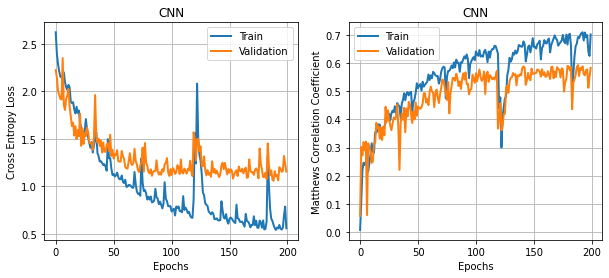

In [4]:
# from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [3]
dropout_rate = 0.1

for kernel_dim in kernel_dims:
    conv2d_config = {
        "filters": 16, 
         "kernel_size": (kernel_dim,kernel_dim), 
         "padding": 'same', 
         "activation": 'relu'
    }
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(dropout_rate)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[MatthewsCorrelationCoefficient(num_classes=10)])
model.summary()

# fit model
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(
    x=X_train, 
    y=y_train,
    epochs=200, 
    class_weight=class_weight,
    validation_split=0.25
)


# MatthewsCorrelationCoefficient(num_classes=10)
# graph train and validation accuracies over epochs
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'], linewidth=2.0, label='Train')
ax1.plot(history.history['val_loss'], linewidth=2.0, label='Validation')
ax1.set_title("CNN")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cross Entropy Loss")
ax1.legend()
ax1.grid()

ax2.plot(history.history['MatthewsCorrelationCoefficient'], linewidth=2.0, label='Train')
ax2.plot(history.history['val_MatthewsCorrelationCoefficient'], linewidth=2.0, label='Validation')
ax2.set_title("CNN")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Matthews Correlation Coefficient")
ax2.legend()
ax2.grid()
fig.set_size_inches(10,4)
fig.show()

model.evaluate(X_test, y_test)

# Experiment 2: Conv2d 3 + dropout = 0.2

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 65568)]           0         
_________________________________________________________________
reshape (Reshape)            (None, 96, 683, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 683, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 341, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 341, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 341, 16)       2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 170, 16)       0     

[1.3824779987335205, 0.4510635733604431]

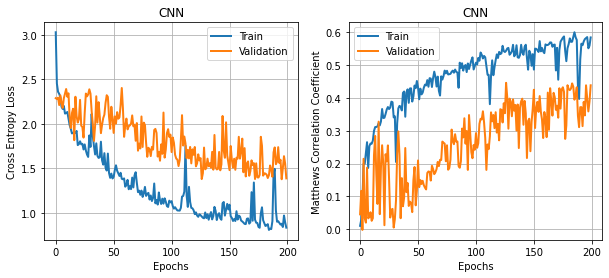

In [5]:
# from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [3]
dropout_rate = 0.2

for kernel_dim in kernel_dims:
    conv2d_config = {
        "filters": 16, 
         "kernel_size": (kernel_dim,kernel_dim), 
         "padding": 'same', 
         "activation": 'relu'
    }
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(dropout_rate)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[MatthewsCorrelationCoefficient(num_classes=10)])
model.summary()

# fit model
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(
    x=X_train, 
    y=y_train,
    epochs=200, 
    class_weight=class_weight,
    validation_split=0.25
)


# MatthewsCorrelationCoefficient(num_classes=10)
# graph train and validation accuracies over epochs
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'], linewidth=2.0, label='Train')
ax1.plot(history.history['val_loss'], linewidth=2.0, label='Validation')
ax1.set_title("CNN")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cross Entropy Loss")
ax1.legend()
ax1.grid()

ax2.plot(history.history['MatthewsCorrelationCoefficient'], linewidth=2.0, label='Train')
ax2.plot(history.history['val_MatthewsCorrelationCoefficient'], linewidth=2.0, label='Validation')
ax2.set_title("CNN")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Matthews Correlation Coefficient")
ax2.legend()
ax2.grid()
fig.set_size_inches(10,4)
fig.show()

model.evaluate(X_test, y_test)

---
# OLD STUFF 
# Experiment 2

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

# GROUP 1
conv2d_config = {"filters": 16, "kernel_size": (2,2), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 2
conv2d_config = {"filters": 16, "kernel_size": (3,3), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
layer = tf.keras.layers.Concatenate()(flattened_layers)
layer = tf.keras.layers.Dense(units=256)(layer)
layer = tf.keras.layers.Dense(units=128)(layer)
layer = tf.keras.layers.Dense(units=64)(layer)
layer = tf.keras.layers.Dense(units=32)(layer)
layer = tf.keras.layers.Dense(units=16)(layer)
output = tf.keras.layers.Dense(units=10)(layer)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=[MatthewsCorrelationCoefficient(num_classes=10)])
model.summary()

# fit model
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=100, 
#                     callbacks=[es],
                    class_weight=class_weight,
                    validation_split=0.25)

# MatthewsCorrelationCoefficient(num_classes=10)
# graph train and validation accuracies over epochs
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'], linewidth=2.0, label='Train')
ax1.plot(history.history['val_loss'], linewidth=2.0, label='Validation')
ax1.set_title("CNN")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cross Entropy Loss")
ax1.legend()
ax1.grid()

ax2.plot(history.history['MatthewsCorrelationCoefficient'], linewidth=2.0, label='Train')
ax2.plot(history.history['val_MatthewsCorrelationCoefficient'], linewidth=2.0, label='Validation')
ax2.set_title("CNN")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Matthews Correlation Coefficient")
ax2.legend()
ax2.grid()
fig.set_size_inches(10,4)
fig.show()

model.evaluate(X_test, y_test)

# Experiment 3: Groups of Conv2d layers 4->16->64

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

# GROUP 1
conv2d_config = {"filters": 16, "kernel_size": (4,4), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 2
conv2d_config = {"filters": 16, "kernel_size": (16,16), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 3
conv2d_config = {"filters": 16, "kernel_size": (64,64), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    batch_size=64,
                    epochs=50, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 4: Conv2D 2+3

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

# GROUP 1
conv2d_config = {"filters": 16, "kernel_size": (2,2), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 2
conv2d_config = {"filters": 16, "kernel_size": (3,3), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=100, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 5: Conv2D 2+3 + Dropout = 0.1

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

# GROUP 1
conv2d_config = {"filters": 16, "kernel_size": (2,2), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
    layer = tf.keras.layers.Dropout(0.1)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 2
conv2d_config = {"filters": 16, "kernel_size": (3,3), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
    layer = tf.keras.layers.Dropout(0.1)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 6: Conv2D 2+3 + Dropout = 0.2

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

# GROUP 1
conv2d_config = {"filters": 16, "kernel_size": (2,2), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 2
conv2d_config = {"filters": 16, "kernel_size": (3,3), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
    layer = tf.keras.layers.Dropout(0.2)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 7: Conv2D 2+3 + Dropout = 0.3

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

# GROUP 1
conv2d_config = {"filters": 16, "kernel_size": (2,2), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
    layer = tf.keras.layers.Dropout(0.3)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# GROUP 2
conv2d_config = {"filters": 16, "kernel_size": (3,3), "padding": 'same', "activation": 'relu'}
maxpooling2d_config = {"pool_size": (2,2)}

layer = reshape
for i in range(6):
    layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
    layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
    layer = tf.keras.layers.Dropout(0.3)(layer)
flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 8: Conv2D: 2+3+5 + Dropout = 0.1

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2, 3, 5]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, "kernel_size": (kernel_dim,kernel_dim), "padding": 'same', "activation": 'relu'}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 9: Conv2D 2+3+5+7 + Dropout = 0.1

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2, 3, 5, 7]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, "kernel_size": (kernel_dim,kernel_dim), "padding": 'same', "activation": 'relu'}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 10: Conv2D 2+3+5+7+11 + dropout = 0.1

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2, 3, 5, 7, 11]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, "kernel_size": (kernel_dim,kernel_dim), "padding": 'same', "activation": 'relu'}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 11: Conv2D 2-13 + dropout = 0.1

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2, 3, 5, 7, 11, 13]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, "kernel_size": (kernel_dim,kernel_dim), "padding": 'same', "activation": 'relu'}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 12: Conv2D 2-17 + dropout = 0.1

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2, 3, 5, 7, 11, 13, 17]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, "kernel_size": (kernel_dim,kernel_dim), "padding": 'same', "activation": 'relu'}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 13: Conv2D 2+3 (double), dropout = 0.1

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2, 3]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, "kernel_size": (kernel_dim,kernel_dim), "padding": 'same', "activation": 'relu'}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.MaxPooling2D(**maxpooling2d_config)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# Experiment 14: Conv2d 2, batchnorm + dropout = 0.1

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
input = tf.keras.Input(shape=(65568,))
reshape = tf.keras.layers.Reshape((96, 683, 1))(input)

flattened_layers = []

kernel_dims = [2]

for kernel_dim in kernel_dims:
    conv2d_config = {"filters": 16, 
                     "kernel_size": (kernel_dim,kernel_dim), 
                     "activation": 'relu', 
                     "strides": (2,2)}
    maxpooling2d_config = {"pool_size": (2,2)}

    layer = reshape
    for i in range(6):
        layer = tf.keras.layers.Conv2D(**conv2d_config)(layer)
        layer = tf.keras.layers.BatchNormalization(axis=2)(layer)
        layer = tf.keras.layers.Dropout(0.1)(layer)
    flattened_layers.append(tf.keras.layers.Flatten()(layer))

# concat all groups
concat = tf.keras.layers.Concatenate()(flattened_layers)
output = tf.keras.layers.Dense(units=10)(concat)

model = tf.keras.models.Model(inputs=input, outputs=output)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    weighted_metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
history = model.fit(x=X_train, 
                    y=y_train,
                    epochs=500, 
                    callbacks=[es],
                    class_weight=class_weight,
                    validation_data=(X_test,y_test))

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()